<a href="https://colab.research.google.com/github/jkcg-learning/FaceMask_ImageClassification/blob/master/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
%load_ext tensorboard

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime

print(tf.__version__)

2.3.0


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1_W2gFFZmy6ZyC8TPlxB49eDFswdBsQqo',
                                    dest_path='/content/FaceMaskDetection.zip',
                                    unzip=True)

Unzipping...Done.


In [4]:
#importing necessary libraries
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
class_names = ['without_mask','with_mask']
IMG_SIZE = 224

In [5]:
import pandas as pd
train_data = pd.read_csv('./face_mask_detection/Training_set_face_mask.csv')
train_data

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask
...,...,...
11259,Image_11260.jpg,with_mask
11260,Image_11261.jpg,with_mask
11261,Image_11262.jpg,with_mask
11262,Image_11263.jpg,with_mask


In [6]:
file_paths = [[fname, './face_mask_detection/train/' + fname] for fname in train_data['filename']]
file_paths[0:5]

[['Image_1.jpg', './face_mask_detection/train/Image_1.jpg'],
 ['Image_2.jpg', './face_mask_detection/train/Image_2.jpg'],
 ['Image_3.jpg', './face_mask_detection/train/Image_3.jpg'],
 ['Image_4.jpg', './face_mask_detection/train/Image_4.jpg'],
 ['Image_5.jpg', './face_mask_detection/train/Image_5.jpg']]

In [7]:
# Confirm if number of images is same as number of labels given
if len(train_data) == len(file_paths):
    print('Number of labels i.e. ', len(train_data), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  11264 matches the number of filenames i.e.  11264


In [8]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,./face_mask_detection/train/Image_1.jpg
1,Image_2.jpg,./face_mask_detection/train/Image_2.jpg
2,Image_3.jpg,./face_mask_detection/train/Image_3.jpg
3,Image_4.jpg,./face_mask_detection/train/Image_4.jpg
4,Image_5.jpg,./face_mask_detection/train/Image_5.jpg


In [9]:
train_data_modified = pd.merge(images, train_data, how = 'inner', on = 'filename')
train_data_modified.head() 

,filename,filepaths,label
0,Image_1.jpg,./face_mask_detection/train/Image_1.jpg,without_mask
1,Image_2.jpg,./face_mask_detection/train/Image_2.jpg,without_mask
2,Image_3.jpg,./face_mask_detection/train/Image_3.jpg,without_mask
3,Image_4.jpg,./face_mask_detection/train/Image_4.jpg,without_mask
4,Image_5.jpg,./face_mask_detection/train/Image_5.jpg,without_mask


In [10]:
train_data_modified.tail() 

,filename,filepaths,label
11259,Image_11260.jpg,./face_mask_detection/train/Image_11260.jpg,with_mask
11260,Image_11261.jpg,./face_mask_detection/train/Image_11261.jpg,with_mask
11261,Image_11262.jpg,./face_mask_detection/train/Image_11262.jpg,with_mask
11262,Image_11263.jpg,./face_mask_detection/train/Image_11263.jpg,with_mask
11263,Image_11264.jpg,./face_mask_detection/train/Image_11264.jpg,with_mask


In [11]:
train_data_without_mask = train_data_modified[train_data_modified['label'] == 'without_mask']
train_data_without_mask

,filename,filepaths,label
0,Image_1.jpg,./face_mask_detection/train/Image_1.jpg,without_mask
1,Image_2.jpg,./face_mask_detection/train/Image_2.jpg,without_mask
2,Image_3.jpg,./face_mask_detection/train/Image_3.jpg,without_mask
3,Image_4.jpg,./face_mask_detection/train/Image_4.jpg,without_mask
4,Image_5.jpg,./face_mask_detection/train/Image_5.jpg,without_mask
...,...,...,...
5627,Image_5628.jpg,./face_mask_detection/train/Image_5628.jpg,without_mask
5628,Image_5629.jpg,./face_mask_detection/train/Image_5629.jpg,without_mask
5629,Image_5630.jpg,./face_mask_detection/train/Image_5630.jpg,without_mask
5630,Image_5631.jpg,./face_mask_detection/train/Image_5631.jpg,without_mask


In [12]:
train_data_mask = train_data_modified[train_data_modified['label'] == 'with_mask']
train_data_mask

,filename,filepaths,label
5632,Image_5633.jpg,./face_mask_detection/train/Image_5633.jpg,with_mask
5633,Image_5634.jpg,./face_mask_detection/train/Image_5634.jpg,with_mask
5634,Image_5635.jpg,./face_mask_detection/train/Image_5635.jpg,with_mask
5635,Image_5636.jpg,./face_mask_detection/train/Image_5636.jpg,with_mask
5636,Image_5637.jpg,./face_mask_detection/train/Image_5637.jpg,with_mask
...,...,...,...
11259,Image_11260.jpg,./face_mask_detection/train/Image_11260.jpg,with_mask
11260,Image_11261.jpg,./face_mask_detection/train/Image_11261.jpg,with_mask
11261,Image_11262.jpg,./face_mask_detection/train/Image_11262.jpg,with_mask
11262,Image_11263.jpg,./face_mask_detection/train/Image_11263.jpg,with_mask


In [13]:
import os
def move_file(old_file_path, new_directory):
    if not os.path.isdir(new_directory):
        os.mkdir(new_directory)
    base_name = os.path.basename(old_file_path)
    new_file_path = os.path.join(new_directory, base_name)
    # Deletes a file if that file already exists there, you can change this behavior
    if os.path.exists(new_file_path):
        os.remove(new_file_path)
    os.rename(old_file_path, new_file_path)


In [14]:
destination_folder_without_mask = './face_mask_detection/train/0_without_mask'
destination_folder_with_mask = './face_mask_detection/train/1_with_mask'

for file_without_mask in train_data_without_mask['filepaths']:
  move_file(file_without_mask, destination_folder_without_mask) 


for file_mask in train_data_mask['filepaths']:
  move_file(file_mask, destination_folder_with_mask)

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

train_generator = train_datagen.flow_from_directory("./face_mask_detection/train/",
                                                    batch_size = 16,
                                                    subset="training",
                                                    class_mode = 'binary', 
                                                    target_size = (224,224))

val_generator = val_datagen.flow_from_directory("./face_mask_detection/train/",
                                                    batch_size = 16,
                                                    subset = "validation",
                                                    class_mode = 'binary', 
                                                    target_size = (224,224))


Found 9012 images belonging to 2 classes.
Found 2252 images belonging to 2 classes.


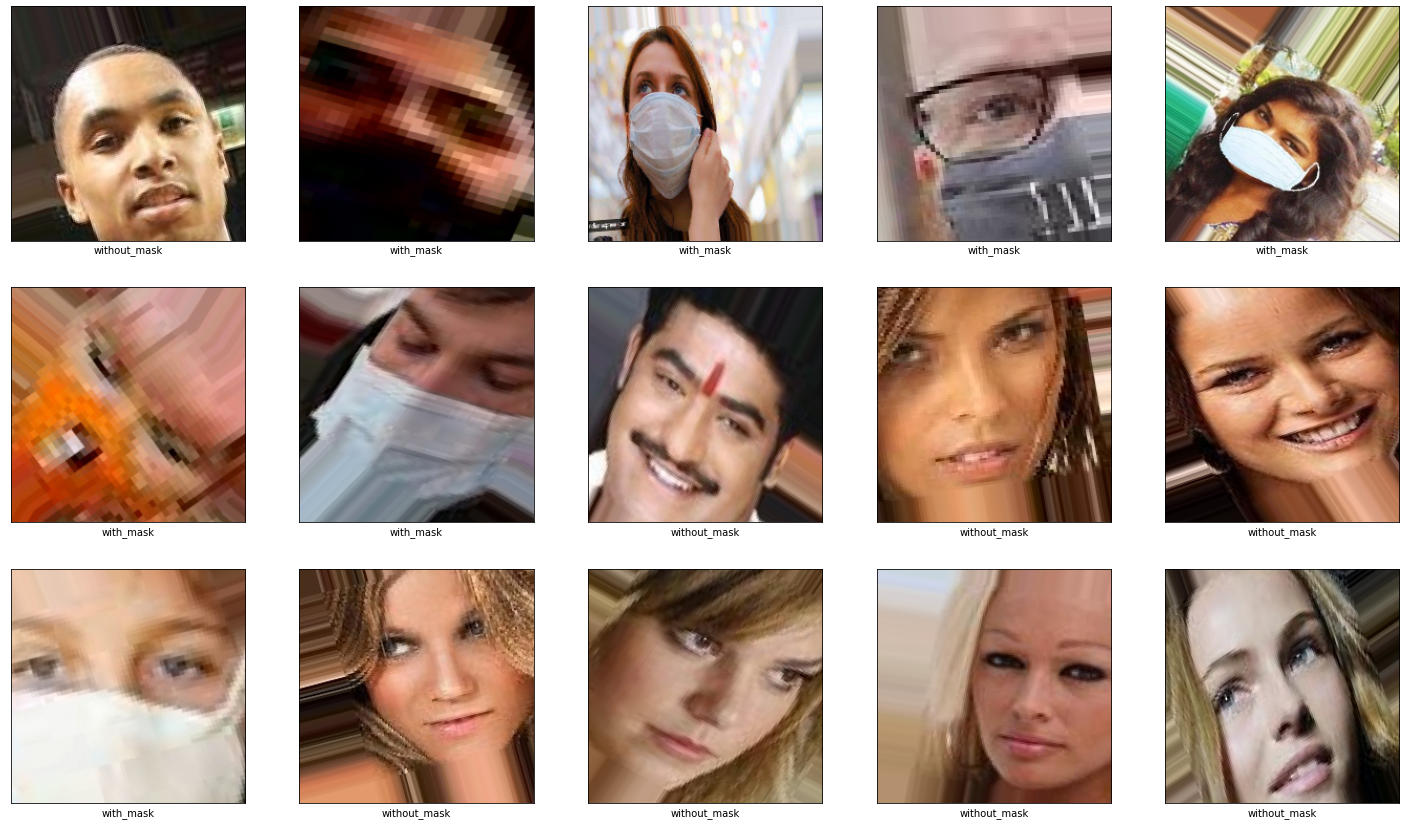

In [16]:
from keras.preprocessing import image as imageDisplay

x,y = train_generator.next()
plt.figure(figsize=(25,25))

for i in range(15):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  imageDisplay = x[i]
  label = y[i]
  plt.imshow(imageDisplay)     
  plt.imshow(imageDisplay)
  if(label == 0.0):
    plt.xlabel(class_names[0])
  elif(label == 1.0):
    plt.xlabel(class_names[1])


In [17]:
lrr= ReduceLROnPlateau(
                       monitor='val_loss', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_loss, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [18]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [19]:
# plotting helper function
def plotaccuracy(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [20]:
# plotting helper function
def plotloss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [21]:
# define input shape
INPUT_SHAPE_RESNET = (224, 224, 3)

# get the Resnet model
ResNet_layers = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE_RESNET)

ResNet_layers.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [22]:
# Fine-tune all the layers
for layer in ResNet_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in ResNet_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8d1b137c18> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f8d1b620cc0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8d1b620c88> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f8d1d28df60> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f8d1b1459b0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f8d1b1456a0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8d1b0d4a58> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8d1ae68fd0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f8d1ae7ff60> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f8d1ae8cf28> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8d1ae8cef0> True
<tensorflow.python.keras.layers.normaliz

In [23]:
# define sequential model
model_ResNet = Sequential()

# Add the efficientNet convolutional base model
model_ResNet.add(ResNet_layers)

# add flatten layer
model_ResNet.add(Flatten())


model_ResNet.add(Dense(256, activation='relu'))
model_ResNet.add(Dropout(0.3))
model_ResNet.add(Dense(128, activation='relu'))
model_ResNet.add(Dropout(0.2))
model_ResNet.add(Dense(1, activation='sigmoid'))


# compile model
model_ResNet.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
model_ResNet.summary()

# view model layers
model_ResNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [ ]:
EPOCHS = 10

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, 
                                               restore_best_weights=True,
                                               verbose=2)

history_RESNET = model_ResNet.fit(train_generator,
                    validation_data = val_generator,
                    batch_size=32,
                    callbacks=[es_callback], 
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/10
564/564 [==============================] - 126s 223ms/step - loss: 0.1003 - accuracy: 0.9672 - val_loss: 1.7156 - val_accuracy: 0.5351
Epoch 2/10
548/564 [============================>.] - ETA: 3s - loss: 0.0276 - accuracy: 0.9907

In [ ]:
plotaccuracy(history_RESNET)

In [ ]:
plotloss(history_RESNET)

In [ ]:
test_data = pd.read_csv('./face_mask_detection/Testing_set_face_mask.csv')
test_data

In [ ]:
test_data['label'] = "./face_mask_detection/test/" + test_data['filename']
test_data


In [ ]:
data_test = []

try:
    #files = glob.glob("./data/animal_dataset_intermediate/test"+"/*") # get files in each folder(class)
    files = test_data['label']
    for f in files:
      img = cv2.imread(f) #read the image
      img = cv2.resize(img,(IMG_SIZE,IMG_SIZE)) #resize the image
      data_test.append([np.array(img)]) #Append images and corresponding labels to data
except:
    pass   
    

In [ ]:
type(data_test)


In [ ]:
data_test_tf = tf.convert_to_tensor(data_test, np.float32)
print(type(data_test_tf))
data_test_tf[0]

In [ ]:
data_test_tf_reshaped = tf.reshape(data_test_tf,[1536 ,224,224,3])
data_test_tf_reshaped.shape

In [ ]:
data_test_normalized = np.divide(data_test_tf_reshaped, 255.0)
data_test_normalized[0]

In [ ]:
preds = model_ResNet.predict(data_test_normalized)

In [ ]:
preds

In [ ]:
prediction = []
for value in preds:
  if value < 0.5:
    prediction.append(0)      # it can be 0 or your respective class
  else:
    prediction.append(1)  

In [ ]:
prediction[0:10]

In [ ]:
#Accessing classnames with predicted clases
final_predictions = [class_names[i] for i in prediction]
print(final_predictions[0:1536])

In [ ]:
plt.figure(figsize=(25,25))

for i in range(15):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cv2.cvtColor(data_test_normalized[i], cv2.COLOR_BGR2RGB))  
  plt.xlabel(final_predictions[i])
  

plt.show()